# Multitaper Windows - Class Interface

The SHWindow class provides an interface to compute window functions that concentrate energy spatially into a given region and in frequency to low degrees. This allows to generate a quality coupling matrix, that couples degrees over a range that is as little as possible.

Say, for example, that we would like to determine the spectrum of the bathymetry of the Earth and compare it with the land spectrum. To this end, we generate window functions for the land and the oceans. 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from pyshtools.shclasses import SHCoeffs, SHGrid, SHWindow


pyshtools 3.3-beta -- Tools for working with spherical harmonics.


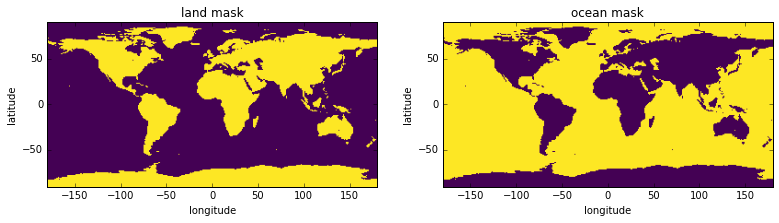

In [2]:
# read earth topography example data
infile = '../ExampleDataFiles/topo.dat.gz'
topo = np.loadtxt(infile)
nlat, nlon = topo.shape
lmax = nlat / 2 - 1
land_mask = (topo > 0)
ocean_mask = ~land_mask

# plot
fig, (col1, col2) = plt.subplots(1, 2, figsize= (13, 5))
col1.imshow(land_mask, extent=(-180, 180, -90, 90), cmap='viridis')
col1.set(xlabel='longitude', ylabel='latitude', title='land mask')
col2.imshow(ocean_mask, extent=(-180, 180, -90, 90), cmap='viridis')
col2.set(xlabel='longitude', ylabel='latitude', title='ocean mask');

## optimally concentrated window functions

SHTOOLS provides a method to solve the so called *concentration problem*, i.e. to find a window that is optimally concentrated in a given region with band-limited coefficient energy below a certain *lmax*. The smaller the region, the larger should be *lmax* to allow for a good concentration. Because the oceans span a larger region, *lmax_ocean* can therefore be smaller than *lmax_land* while still getting well concentrated windows. The *concentration* value that is indicated above the plots, shows the energy of the window that lies within the original region. The final spectrum is a (possibly weighted) average of the individual spectral measurements.

ocean windows
kind = 'mask'
lmax = 7
nwin = 10
Taper weights are not set.


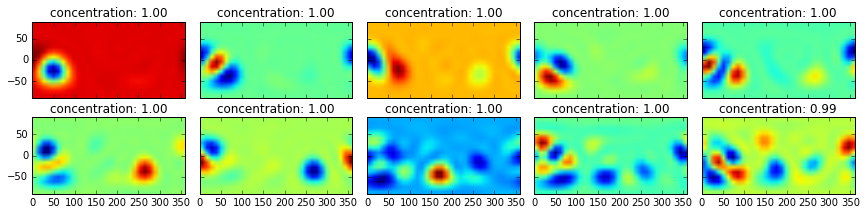

land windows
kind = 'mask'
lmax = 11
nwin = 10
Taper weights are not set.


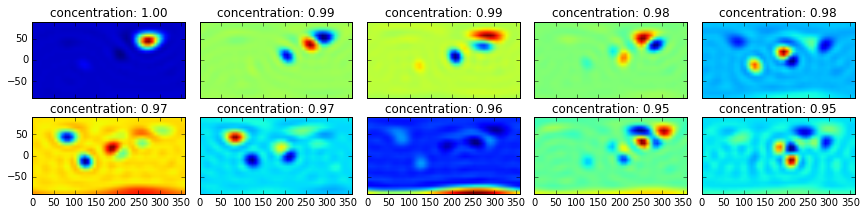

In [3]:
lmax_ocean = 7
lmax_land = 11
nwins = 10
ocean_windows = SHWindow.from_mask(ocean_mask, lmax_ocean, nwins)
land_windows = SHWindow.from_mask(land_mask, lmax_land, nwins)

print 'ocean windows'
ocean_windows.info()
ocean_windows.plot_windows(nwins, show=True)
print 'land windows'
land_windows.info()
land_windows.plot_windows(nwins, show=True)

The following plot shows how power of the land windows extents to larger degrees than the power of the ocean windows, that are constraint with a lower *lmax*. Of course, the ocean will allow for higher quality measurements at lower degrees.

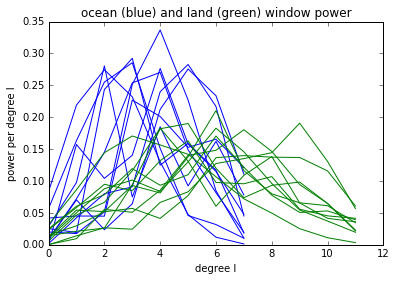

In [4]:
winpower_land = land_windows.get_powerperdegree()
winpower_ocean = ocean_windows.get_powerperdegree()

fig, ax = plt.subplots(1, 1)
for itaper in range(nwins):
    ax.plot(winpower_ocean[:, itaper], c='blue')
    
for itaper in range(nwins):
    ax.plot(winpower_land[:, itaper], c='green')

ax.set(xlabel='degree l', ylabel='power per degree l',
       title='ocean (blue) and land (green) window power');

## the coupling matrix

The coupling matrix reflects the different quality of the land and ocean spectra. The higher degree part (towards the bottom right) corresponds to a simple convolution. It becomes asymptotically symmetric around the diagonal. The land windows couple degrees over a wider range and therefore decrease the spectral resolution that can be achieved.

The second effect is the asymmetric part of the coupling matrix towards low degrees: Low input degrees map to higher output degrees. E.g. input degree 0 maps strongest to around degree 3 in the ocean case and to around degree 6 in the land case. This is the consequence that we can not estimate the global mean or very large wavelength structures from subregions that are much smaller. Low degree energy maps therefore to the lowest window degrees, where they increase the overall power.

Smoothing and bias need to be considered when comparing spectra that have been obtained with two different windows.

ocean coupling matrix
land coupling matrix


[(51, 0.0), (-0.5, 40.5)]

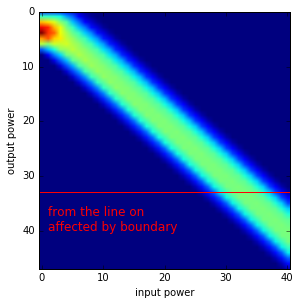

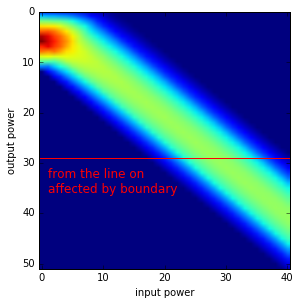

In [5]:
lmax_data = 40

print 'ocean coupling matrix'
lmax_valid1 = lmax_data - lmax_ocean
lmax_full1 = lmax_data + lmax_ocean
fig1, ax1 = ocean_windows.plot_couplingmatrix(lmax_data, nwins,
                                              mode='full', show=False)
ax1.plot([-0.5, lmax_data + 0.5], [lmax_valid1, lmax_valid1], c='red')
ax1.text(1, lmax_valid1 + 7, 'from the line on\naffected by boundary', fontsize=12, color='red')
ax1.set(xlim=(-0.5, lmax_data + 0.5), ylim=(lmax_full1, 0.))

print 'land coupling matrix'
fig2, ax2 = land_windows.plot_couplingmatrix(lmax_data, nwins,
                                             mode='full', show=False)
lmax_valid2 = lmax_data - lmax_land
lmax_full2 = lmax_data + lmax_land
ax2.plot([-0.5, lmax_data + 0.5], [lmax_valid2, lmax_valid2], c='red')
ax2.text(1, lmax_valid2 + 7, 'from the line on\naffected by boundary', fontsize=12, color='red')
ax2.set(xlim=(-0.5, lmax_data+0.5), ylim=(lmax_full2, 0.))

The coupling matrix describes the expected coupling between coefficients that are independent (stationary and isotropic models). Obviously, the toography of the Earth is not stationary and isotropic and a simple prediction about a regional measurement can therefore not be made. For example, if a non-stationary model is zero in the windowed region, the local spectrum will also be zero and not the global spectrum distorted by the coupling matrix.

Nevertheless, the coupling matrix is useful, because it allows us to differentiate between the effect of the window and the effect due to a particular region, that can have a particular power spectrum as well in the case of a non-stationary model.

### regional spectral estimates

We are now in a position to compute regional power spectral estimates of the land and of the ocean topography as well as the corresponding power spectra that we would *expect* to see on land and in the ocean if Earth's topography was stationary and isotropic.

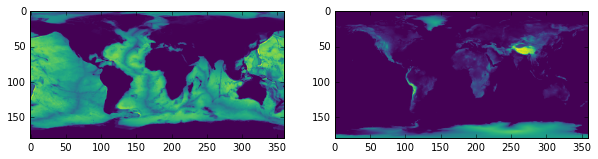

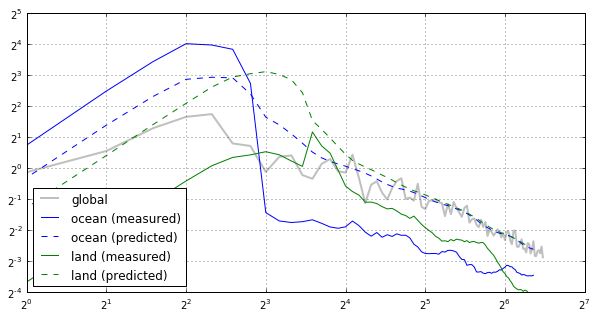

In [6]:
# get topography sh coefficients:
grid_topo = SHGrid.from_array(topo)
coeffs_topo = grid_topo.expand()
power_global = coeffs_topo.get_powerperdegree()
lmax_global = coeffs_topo.lmax
ls_global = np.arange(len(power_global))

# get measured and predicted ocean spectrum
power_ocean, dpower_ocean = ocean_windows.get_multitaperpowerspectrum(coeffs_topo, nwins)
cmatrix_ocean = ocean_windows.get_couplingmatrix(lmax_global, nwins, mode='valid')
power_ocean_predicted = np.dot(cmatrix_ocean, power_global)
ls_ocean = np.arange(len(power_ocean))

# get measured and predicted land spectrum
power_land, dpower_land = land_windows.get_multitaperpowerspectrum(coeffs_topo, nwins)
cmatrix_land = land_windows.get_couplingmatrix(lmax_global, nwins, mode='valid')
power_land_predicted = np.dot(cmatrix_land, power_global)
ls_land = np.arange(len(power_land))

# plot ocean and land topography
fig, (col1, col2) = plt.subplots(1, 2, figsize=(10, 5))
col1.imshow(-topo * ocean_mask, cmap='viridis')
col2.imshow(topo * land_mask, cmap='viridis')

# plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(ls_global, power_global * ls_global, c='grey', alpha=0.5, lw=2, label='global')

ax.plot(ls_ocean, power_ocean * ls_ocean, '-', c='blue', label='ocean (measured)')
ax.plot(ls_ocean, power_ocean_predicted * ls_ocean, '--', c='blue', label='ocean (predicted)')

ax.plot(ls_land, power_land * ls_land, '-', c='green', label='land (measured)')
ax.plot(ls_land, power_land_predicted * ls_land, '--', c='green', label='land (predicted)')

ax.legend(loc=3)
ax.grid(True)
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)

As we would have expected, the power spectra are vastly different. The ocean spectrum is dominated by the strong low degrees, which is not surprising due to a large negative mean. The land spectrum is entirely missing the long degree component because it doesn't deviate much from 0 altitude, except in mountain ranges. On the other hand, the ocean shows weaker small scale variations than the land spectrum.

Note that the definition of the windows largely excludes continental shelfs, that are at the boundaries of the mask and that have strong small scale power.

The difference between the predicted land and ocean spectra demonstrate, that even if Earth's topography was stationary, the window functions cause different power spectra. We illustrate this in the next plot where we replace Earth's topography with a random model that has the same (with fluctuations) power spectrum but that is stationary.

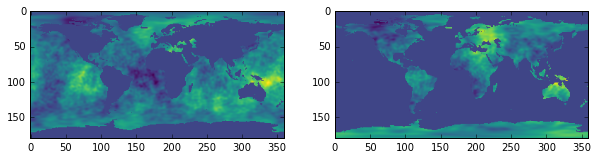

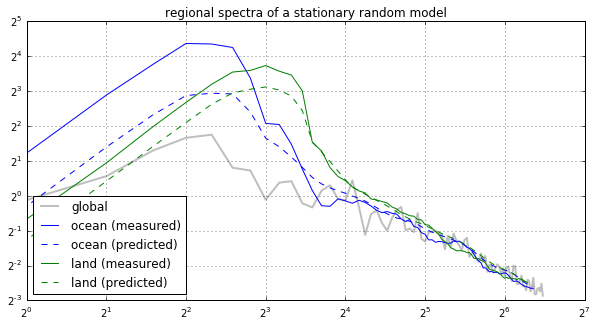

In [7]:
# get stationary random model:
np.random.seed(0)  # fix seed for reproducable figure
coeffs_stationary = SHCoeffs.from_random(power_global)
grid_stationary = coeffs_stationary.expand('DH2')

# get measured and predicted ocean spectrum
power_ocean, dpower_ocean = ocean_windows.get_multitaperpowerspectrum(coeffs_stationary, nwins)
cmatrix_ocean = ocean_windows.get_couplingmatrix(lmax_global, nwins, mode='valid')
power_ocean_predicted = np.dot(cmatrix_ocean, power_global)
ls_ocean = np.arange(len(power_ocean))

# get measured and predicted land spectrum
power_land, dpower_land = land_windows.get_multitaperpowerspectrum(coeffs_stationary, nwins)
cmatrix_land = land_windows.get_couplingmatrix(lmax_global, nwins, mode='valid')
power_land_predicted = np.dot(cmatrix_land, power_global)
ls_land = np.arange(len(power_land))

# plot ocean and land topography
fig, (col1, col2) = plt.subplots(1, 2, figsize=(10, 5))
col1.imshow(grid_stationary.data * ocean_mask, cmap='viridis')
col2.imshow(grid_stationary.data * land_mask, cmap='viridis')

# plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(ls_global, power_global * ls_global, c='grey', alpha=0.5, lw=2,
        label='global')

ax.plot(ls_ocean, power_ocean * ls_ocean, '-', c='blue', label='ocean (measured)')
ax.plot(ls_ocean, power_ocean_predicted * ls_ocean, '--', c='blue',
        label='ocean (predicted)')

ax.plot(ls_land, power_land * ls_land, '-', c='green', label='land (measured)')
ax.plot(ls_land, power_land_predicted * ls_land, '--', c='green',
        label='land (predicted)')

ax.set(title='regional spectra of a stationary random model')
ax.legend(loc=3)
ax.grid(True)
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)

The regional estimates of the stationary model, resemble closely the predicted ones. In particular low degrees are more sensitive to fluctuations of the random model, such that there are some differences.

To compare global, ocean and land spectra, the coupling matrix can be *inverted* to remove the bias. In the case of the stationary model, we expect to retrieve the same original input power spectrum, because apart from random fluctuations, the differences of the power spectra are entirely due to the window effects.

In the case of the real non-stationary topography of the Earth on the other hand, we are going to get three power spectra that correspond to equivalent stationary global models that have the observed regional spectra. These spectra can be observed.

The inversion has to be done with care, because the coupling matrix is singular.